# FISH comparison

Data: https://drive.google.com/drive/folders/1uos3DDymyrh3ZyxveDhqQIcOyD1brxeL

In [136]:
import pandas as pd
import seaborn as sns
import scanpy as sc
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import itertools

In [137]:
data_path = '/home/ubuntu/Data/smfish/'

In [138]:
# dropseq = pd.read_csv(data_path + 'melanoma_dropseq.csv', index_col=0, sep=',').T
# dropseq = dropseq[dropseq['GAPDH'] > 0]

In [139]:
smfish = pd.read_csv(data_path + 'fishSubset.txt', index_col=0, sep=' ')
smfish = smfish[smfish['GAPDH'] > 50]
fish_gapdh_sf = (smfish['GAPDH']).values
smfish_normalized = smfish#/fish_gapdh_sf.reshape(-1, 1)
# smfish = pd.read_csv('fishSubset (1).txt', sep=' ', index_col=0)

In [140]:
# saver_estimates = pd.read_csv('/data_volume/memento/saver/saver_estimates.csv', index_col=0)

In [141]:
# dropseq_sf = dropseq.sum(axis=1).values
# dropseq_sf = dropseq['GAPDH'].values
# unnormalized_saver_estimates = saver_estimates.T*dropseq_sf.reshape(-1,1)
# gapdh_saver_sf = unnormalized_saver_estimates['GAPDH'].values/unnormalized_saver_estimates['GAPDH'].mean()
# normalized_saver_estimates = unnormalized_saver_estimates/gapdh_saver_sf.reshape(-1,1)

In [142]:
# saver_corrs_all = pd.read_csv('/data_volume/memento/saver/saver_corrs.csv', index_col=0)

In [143]:
def concordance(x, y, log=False):
    
    nonnan = np.isfinite(x) & np.isfinite(y)
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    
    return stats.pearsonr(a,b)[0]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

### Run memento for DropSeq

In [144]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
%autoreload 3

In [146]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
# sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
# import encode
import memento

In [168]:
# adata = sc.AnnData(X=sparse.csr_matrix(dropseq.values), obs=pd.DataFrame(index=dropseq.index), var=pd.DataFrame(index=dropseq.columns))

adata = sc.read_h5ad(data_path + 'filtered_dropseq.h5ad')
q = 0.01485030176341905
adata.obs['q'] = q
adata.obs['group'] = 'A'
adata.write(data_path + 'dropseq.h5ad')

memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.01,trim_percent=1, shrinkage=0.5)

#Optional
mem_gapdh_sf = (adata[:, 'GAPDH'].X.todense().A1+1)/( adata[:, 'GAPDH'].X.todense().A1+1).mean()
mem_total_sf = adata.obs['memento_size_factor']/adata.obs['memento_size_factor'].mean()
adata.obs['memento_size_factor'] = 1#adata.X.sum(axis=1).A1

memento.create_groups(adata, label_columns=['group'])
memento.compute_1d_moments(adata, filter_genes=True)

dropseq_m, dropseq_v, _ = adata.uns['memento']['1d_moments']['sg^A']
dropseq_fano = dropseq_v/dropseq_m**2

naive_sf = adata.X.sum(axis=1).A1.reshape(-1,1)#/adata.X.sum(axis=1).mean()
naive_sf = 1# adata.obs['memento_size_factor'].values

normalized_dropseq = adata.X.toarray()/naive_sf
naive_m, naive_v = normalized_dropseq.mean(axis=0), normalized_dropseq.var(axis=0)
naive_fano = naive_v/naive_m**2

### Compute fish mean and variance

In [169]:
keep_genes = smfish.columns.tolist()
overlap_genes = list(set(adata.var.index) & set(keep_genes))

overlap_genes.remove('GAPDH')
overlap_gene_idxs = np.array([adata.var.index.tolist().index(g) for g in overlap_genes])

dropseq_m, dropseq_v, naive_m, naive_v = dropseq_m[overlap_gene_idxs], dropseq_v[overlap_gene_idxs], naive_m[overlap_gene_idxs], naive_v[overlap_gene_idxs]
dropseq_fano, naive_fano = dropseq_fano[overlap_gene_idxs], naive_fano[overlap_gene_idxs]

filtered_smfish = smfish_normalized[overlap_genes]

means = np.nanmean(filtered_smfish, axis=0)
variances = np.nanvar(filtered_smfish, axis=0)
corrs = filtered_smfish.corr()
covs = filtered_smfish.cov()
fanos = variances/means**2

naive_corr = np.corrcoef(normalized_dropseq[:, overlap_gene_idxs], rowvar=False)
naive_cov = np.cov(normalized_dropseq[:, overlap_gene_idxs], rowvar=False)


In [170]:
pd.DataFrame(zip(
    overlap_genes, 
    means,
    naive_m), columns=['gene', 'smfish', 'naive']).sort_values('gene')

,gene,smfish,naive
11,BABAM1,8.258707,0.071664
12,C1S,70.781966,0.013650
9,CCNA2,9.539629,0.075547
8,FGFR1,3.845033,0.036126
6,FOSL1,0.103940,0.059543
10,KDM5A,7.352264,0.263591
4,KDM5B,4.790332,0.154036
3,LMNA,151.920925,0.596729
1,MITF,35.470562,1.017181
0,RUNX2,0.726072,0.020240


Text(0.5, 1.0, 'CCC = 0.36')

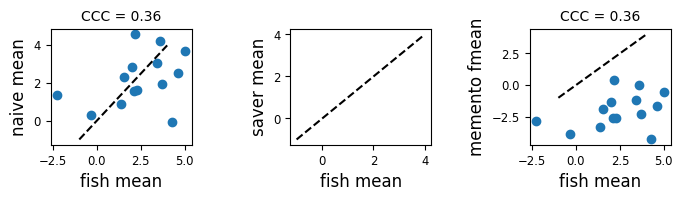

In [171]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(means), np.log(naive_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('naive mean')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(means), np.log(naive_m))))

plt.subplot(1,3,2)
# plt.scatter(np.log(means), np.log(saver_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('saver mean')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(saver_m/q))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(means), np.log(dropseq_m))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('memento fmean')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(means), np.log(dropseq_m))))

# plt.savefig('mean_comparisons.png', dpi=300)

Text(0.5, 1.0, 'CCC = 0.48')

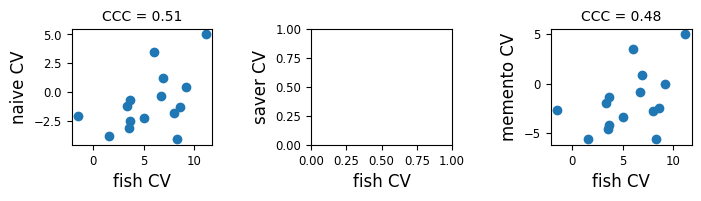

In [156]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(variances), np.log(naive_v))
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(variances), np.log(naive_v))))

plt.subplot(1,3,2)
# plt.scatter(np.log(fanos), np.log(saver_fano))
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(variances), np.log(dropseq_v))
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(variances), np.log(dropseq_v))))

# plt.savefig('variability_comparisons.png', dpi=300)

Text(0.5, 1.0, 'CCC = 0.50')

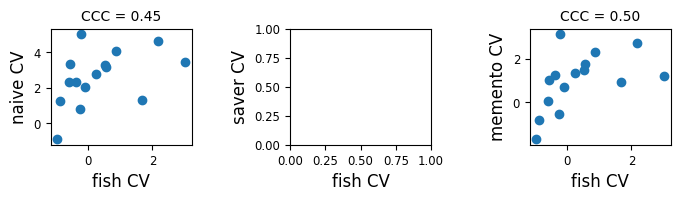

In [151]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(fanos), np.log(naive_fano))
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(fanos), np.log(naive_fano))))

plt.subplot(1,3,2)
# plt.scatter(np.log(fanos), np.log(saver_fano))
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(fanos), np.log(dropseq_fano))
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(fanos), np.log(dropseq_fano))))

# plt.savefig('variability_comparisons.png', dpi=300)

In [152]:
pd.DataFrame(
    zip(overlap_genes, means, variances, naive_m, naive_v, dropseq_m, dropseq_v),
    columns=['gene', 'fish_m', 'fish_v', 'naive_m', 'naive_v', 'hyper_m', 'hyper_v'])\
    .sort_values('gene')

,gene,fish_m,fish_v,naive_m,naive_v,hyper_m,hyper_v
12,BABAM1,8.258707,38.655864,0.000031,2.736789e-08,0.000031,2.689102e-09
13,C1S,70.781966,3989.722976,0.000006,5.763512e-09,0.000006,8.206947e-10
10,CCNA2,9.539629,154.716425,0.000038,3.937181e-08,0.000037,6.217798e-09
9,FGFR1,3.845033,34.836568,0.000016,1.461312e-08,0.000015,2.319096e-09
7,FOSL1,0.103940,0.222666,0.000029,2.618725e-08,0.000028,2.624620e-09
3,GAPDH,431.247254,69997.154544,0.003816,5.905783e-06,0.003753,2.617943e-06
11,KDM5A,7.352264,36.710937,0.000114,1.347654e-07,0.000112,4.444391e-08
5,KDM5B,4.790332,29.243406,0.000061,6.018366e-08,0.000060,1.411365e-08
4,LMNA,151.920925,9385.686830,0.000240,2.084528e-07,0.000236,2.557913e-08
1,MITF,35.470562,964.322050,0.000493,5.562998e-07,0.000485,1.396864e-07


In [118]:
pd.DataFrame(zip(overlap_genes, naive_v, ))

,0,1
0,RUNX2,6.038204e-09
1,MITF,5.562998e-07
2,SOX10,7.519020e-08
3,GAPDH,5.905783e-06
4,LMNA,2.084528e-07
5,KDM5B,6.018366e-08
6,TXNRD1,1.543060e-07
7,FOSL1,2.618725e-08
8,VCL,4.038814e-08
9,FGFR1,1.461312e-08


### Make comparison for correlations

In [119]:
# saver_corrs = saver_corrs_all.loc[overlap_genes, overlap_genes].values.reshape(-1)

In [120]:
memento.compute_2d_moments(adata, gene_pairs=list(itertools.product(overlap_genes, overlap_genes)))

In [121]:
memento_corr_array = adata.uns['memento']['2d_moments']['sg^A']['corr']
memento_cov_array = adata.uns['memento']['2d_moments']['sg^A']['cov']

In [122]:
fish_corr_array = np.array([corrs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])
fish_cov_array = np.array([covs.loc[x,y] for x,y in itertools.product(overlap_genes, overlap_genes)])

In [123]:
selected_pairs = ~np.isnan(fish_corr_array) & (fish_corr_array!=1)

In [124]:
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


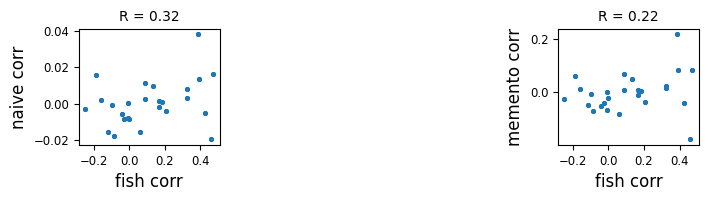

In [125]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('naive corr')
# print('naive', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0])
plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])))
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs])[0]))



# plt.subplot(1,3,2)
# plt.scatter(fish_corr_array[selected_pairs], saver_corrs[selected_pairs], s=7)
# plt.xlabel('fish corr'); plt.ylabel('saver corr')
# # print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('R = '+str(concordance(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])))
# plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0]))


plt.subplot(1,3,3)
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=7)
plt.xlabel('fish corr'); plt.ylabel('memento corr')
# print('memento', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0])
plt.title('R = '+str.format('{0:.2f}', stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]))

plt.savefig('coex_comparisons.png', dpi=300)

In [126]:
stats.pearsonr(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs])[0]

0.2197171015415179

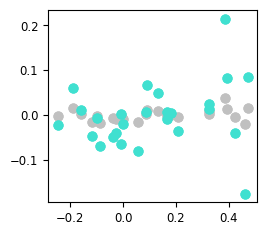

In [127]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(fish_corr_array[selected_pairs], naive_corr.reshape(-1)[selected_pairs], s=40, color='silver')
plt.scatter(fish_corr_array[selected_pairs], memento_corr_array[selected_pairs], s=40, color='turquoise')
# plt.xlabel('smFISH corr'); plt.ylabel('Dropseq corr');
plt.savefig('correlation_comparisons.pdf', bbox_inches='tight')

### Make comparison for mean and variability

In [68]:
# filtered_saver = normalized_saver_estimates[overlap_genes]

In [69]:
# saver_m = np.nanmean(filtered_saver, axis=0)
# saver_v = np.nanvar(filtered_saver, axis=0)
# saver_fano = saver_v/saver_m**2

# a, b, _, _, _= stats.linregress(np.log(saver_m), np.log(saver_v))
# naive_rv = np.log(saver_v)-(np.log(saver_m)*a+b)

In [70]:
n_umi = adata.obs['memento_size_factor'].mean()

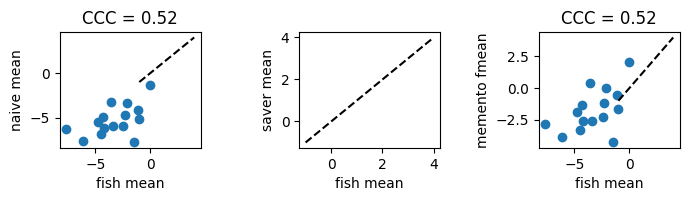

In [71]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(means), np.log(naive_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('naive mean')
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(naive_m/q))[0]))

plt.subplot(1,3,2)
# plt.scatter(np.log(means), np.log(saver_m/q))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('saver mean')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(saver_m/q))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(means), np.log(dropseq_m))
plt.plot([-1, 4],[-1, 4], '--', color='k')
plt.xlabel('fish mean'); plt.ylabel('memento fmean')
plt.title('CCC = '+str.format('{0:.2f}', stats.spearmanr(np.log(means), np.log(dropseq_m))[0]))

plt.savefig('mean_comparisons.png', dpi=300)

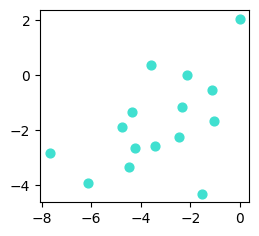

In [72]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(means), np.log(dropseq_m), s=40, color='turquoise')
# plt.xlabel('smFISH log(CV)'); plt.ylabel('Dropseq log(CV)');
plt.savefig('mean_comparisons.pdf', bbox_inches='tight')

In [73]:
variances

array([8.84895720e-05, 5.52493775e-06, 7.87836742e-05, 3.39610558e-02,
       1.23022156e-04, 0.00000000e+00, 4.63960523e-02, 2.77016399e-05,
       1.02234369e-02, 7.10420399e-03, 8.09035704e-02, 3.86241377e-03,
       1.96361612e-03, 8.08699479e-03, 2.85482769e-04])

/tmp/ipykernel_20862/1535659385.py:5: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(variances), np.log(naive_v))
/tmp/ipykernel_20862/1535659385.py:7: RuntimeWarning: divide by zero encountered in log
  plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(variances), np.log(naive_v))[0]))
/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4831: RuntimeWarning: invalid value encountered in subtract
  xm = x.astype(dtype) - xmean


ValueError: array must not contain infs or NaNs

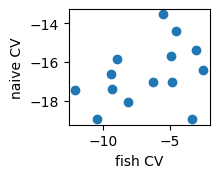

In [74]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(variances), np.log(naive_v))
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(variances), np.log(naive_v))[0]))

plt.subplot(1,3,2)
# plt.scatter(np.log(fanos), np.log(saver_fano))
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(variances), np.log(dropseq_v))
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(variances), np.log(dropseq_v))[0]))

# plt.savefig('variability_comparisons.png', dpi=300)

/tmp/ipykernel_20862/774163193.py:5: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(fanos), np.log(naive_fano))
/tmp/ipykernel_20862/774163193.py:7: RuntimeWarning: divide by zero encountered in log
  plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(fanos), np.log(naive_fano))))
/tmp/ipykernel_20862/774163193.py:16: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(fanos), np.log(dropseq_fano))
/tmp/ipykernel_20862/774163193.py:18: RuntimeWarning: divide by zero encountered in log
  plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(fanos), np.log(dropseq_fano))))


Text(0.5, 1.0, 'CCC = 0.72')

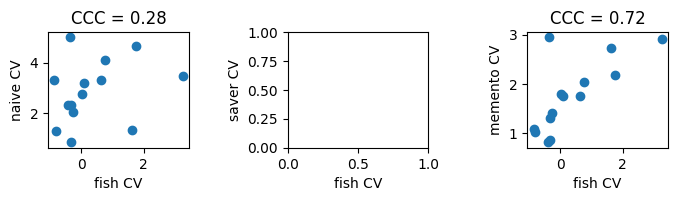

In [75]:
plt.figure(figsize=(8,1.5))
plt.subplots_adjust(wspace=0.7)

plt.subplot(1,3,1)
plt.scatter(np.log(fanos), np.log(naive_fano))
plt.xlabel('fish CV'); plt.ylabel('naive CV')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(fanos), np.log(naive_fano))))

plt.subplot(1,3,2)
# plt.scatter(np.log(fanos), np.log(saver_fano))
plt.xlabel('fish CV'); plt.ylabel('saver CV')
# print('saver', stats.pearsonr(fish_corr_array[selected_pairs], saver_corrs[selected_pairs])[0])
# plt.title('CCC = '+str.format('{0:.2f}', stats.pearsonr(np.log(fanos), np.log(saver_fano))[0]))

plt.subplot(1,3,3)
plt.scatter(np.log(fanos), np.log(dropseq_fano))
plt.xlabel('fish CV'); plt.ylabel('memento CV')
plt.title('CCC = '+str.format('{0:.2f}', concordance(np.log(fanos), np.log(dropseq_fano))))

# plt.savefig('variability_comparisons.png', dpi=300)

In [76]:
result_path = '/data_volume/memento/saver/'

In [ ]:
mean = pd.read_csv(result_path + 'dropseq_BASiCS_mu.csv'.format(q)).mean(axis=0)
delta = pd.read_csv(result_path + 'dropseq_BASiCS_delta.csv'.format(q)).mean(axis=0)
v_basics = mean+delta*mean**2
m_basics = mean
fano_basics = v_basics/m_basics**2

# scaling = (/m_basics)
# m_basics = m_basics*scaling
# v_basics = v_basics*scaling**2


In [ ]:
print('memento', stats.pearsonr(np.log(fanos), np.log(dropseq_fano))[0])
print('naive', stats.pearsonr(np.log(fanos), np.log(naive_fano))[0])
print('basics', stats.pearsonr(np.log(fanos), np.log(fano_basics[overlap_genes]))[0])

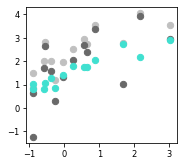

In [135]:
plt.figure(figsize=(2.7,2.5))
plt.scatter(np.log(fanos), np.log(naive_fano), s=40, color='silver')
plt.scatter(np.log(fanos), np.log(fano_basics[overlap_genes]), s=40, color='dimgrey')
plt.scatter(np.log(fanos), np.log(dropseq_fano), s=40, color='turquoise')

# plt.xlabel('smFISH log(CV)'); plt.ylabel('Dropseq log(CV)');
plt.savefig('variability_comparisons.pdf', bbox_inches='tight')